In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib


# 1 - CARREGAMENTO E AJUSTE DOS DADOS

print("Carregando dataset...")

# Olha se o arquivo existe
arquivo = 'Obesity.csv'
if not os.path.exists(arquivo):
    raise FileNotFoundError(f"Erro: O arquivo '{arquivo}' não está na pasta!")

df = pd.read_csv(arquivo)

# LOCALIZAÇÃO AUTOMÁTICA DA COLUNA ALVO
# O PDF pede 'Obesity_level', mas o arquivo real veio como 'Obesity'
coluna_alvo = 'Obesity' 
if coluna_alvo not in df.columns:
    # Tenta achar outro nome comum se 'Obesity' não existir
    for col in ['NObeyesdad', 'Obesity_level']:
        if col in df.columns:
            coluna_alvo = col
            break

print(f"Coluna alvo detectada: '{coluna_alvo}'")

# Separação X (Dados) e y (Target)
X = df.drop(coluna_alvo, axis=1)
y = df[coluna_alvo]


# 2 - FEATURE ENGINEERING (TRATAMENTO)

# Listas de colunas baseadas no tipo de dado
cols_numericas = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
cols_ordinais = ['CAEC', 'CALC']
cols_nominais = ['Gender', 'family_history', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']

# só processar colunas que realmente existem no arquivo
cols_numericas = [c for c in cols_numericas if c in X.columns]
cols_ordinais = [c for c in cols_ordinais if c in X.columns]
cols_nominais = [c for c in cols_nominais if c in X.columns]

# Função p/ arredondar decimais 
def arredondar_valores(X_in):
    X_out = X_in.copy()
    cols_to_round = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
    valid_cols = [c for c in cols_to_round if c in X_out.columns]
    X_out[valid_cols] = X_out[valid_cols].round().astype(int)
    return X_out

# Pipelines de transformação
transformer_num = Pipeline([
    ('arredondar', FunctionTransformer(arredondar_valores, validate=False)),
    ('scaler', StandardScaler())
])

transformer_ord = OrdinalEncoder(
    categories=[['no', 'Sometimes', 'Frequently', 'Always']] * len(cols_ordinais),
    handle_unknown='use_encoded_value', unknown_value=-1
)

transformer_nom = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', transformer_num, cols_numericas),
    ('ord', transformer_ord, cols_ordinais),
    ('nom', transformer_nom, cols_nominais)
])


# 3 - MODELAGEM (RANDOM FOREST)

# Configuração robusta para evitar Overfitting:
# - max_depth=15: Impede a árvore de crescer demais e decorar 
# - min_samples_leaf=2: Garante q cada "folha" tenha pelo menos 2 pacientes
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=100,
        max_depth=15,          
        min_samples_leaf=2,    
        random_state=42
    ))
])

# Separação Treino (80%) e Teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Treinando o modelo Random Forest...")
pipeline.fit(X_train, y_train)


# 4 - AVALIAÇÃO E PROVA REAL (OVERFITTING CHECK)

print("\n" + "_"*40)
print("RESULTADOS DA AVALIAÇÃO")


# Calcula acurácia no treino e no teste
acc_treino = pipeline.score(X_train, y_train)
acc_teste = pipeline.score(X_test, y_test)

print(f"Acurácia no Treino: {acc_treino:.2%}")
print(f"Acurácia no Teste:  {acc_teste:.2%}")

# Cálculo do Gap (Diferença)
gap = acc_treino - acc_teste

if gap > 0.10: # Se a diferença for maior que 10%
    print(f"ALERTA: Gap de {gap:.1%}. Indício de Overfitting!")
    print("   Sugestão: reduzir 'max_depth' ou aumentar 'min_samples_leaf'.")
else:
    print(f"SUCESSO: Gap controlado de apenas {gap:.1%}.")

# Relatório detalhado por classe
print("\nRelatório Detalhado por Classe (Teste):")
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


# 5 - SALVAR O MODELO
nome_arquivo_modelo = 'modelo_obesidade.pkl'
joblib.dump(pipeline, nome_arquivo_modelo)
print(f"\nModelo salvo com sucesso em: '{nome_arquivo_modelo}'")

Carregando dataset...
Coluna alvo detectada: 'Obesity'
Treinando o modelo Random Forest...

________________________________________
RESULTADOS DA AVALIAÇÃO
Acurácia no Treino: 99.47%
Acurácia no Teste:  93.62%
SUCESSO: Gap controlado de apenas 5.8%.

Relatório Detalhado por Classe (Teste):
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.94      0.97        54
      Normal_Weight       0.80      0.88      0.84        58
     Obesity_Type_I       0.96      0.96      0.96        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.85      0.86      0.85        58
Overweight_Level_II       0.98      0.93      0.96        58

           accuracy                           0.94       423
          macro avg       0.94      0.93      0.94       423
       weighted avg       0.94      0.94      0.94       423


Modelo salvo com sucesso em: 'mod

Carregando dataset...
Coluna alvo detectada: 'Obesity'
Treinando o modelo Random Forest...

________________________________________
RESULTADOS DA AVALIAÇÃO
Acurácia no Treino: 99.47%
Acurácia no Teste:  93.62%
SUCESSO: Gap controlado de apenas 5.8%.

Relatório Detalhado por Classe (Teste):
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.94      0.97        54
      Normal_Weight       0.80      0.88      0.84        58
     Obesity_Type_I       0.96      0.96      0.96        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.85      0.86      0.85        58
Overweight_Level_II       0.98      0.93      0.96        58

           accuracy                           0.94       423
          macro avg       0.94      0.93      0.94       423
       weighted avg       0.94      0.94      0.94       423


Gerando gráfico da Matriz de Conf

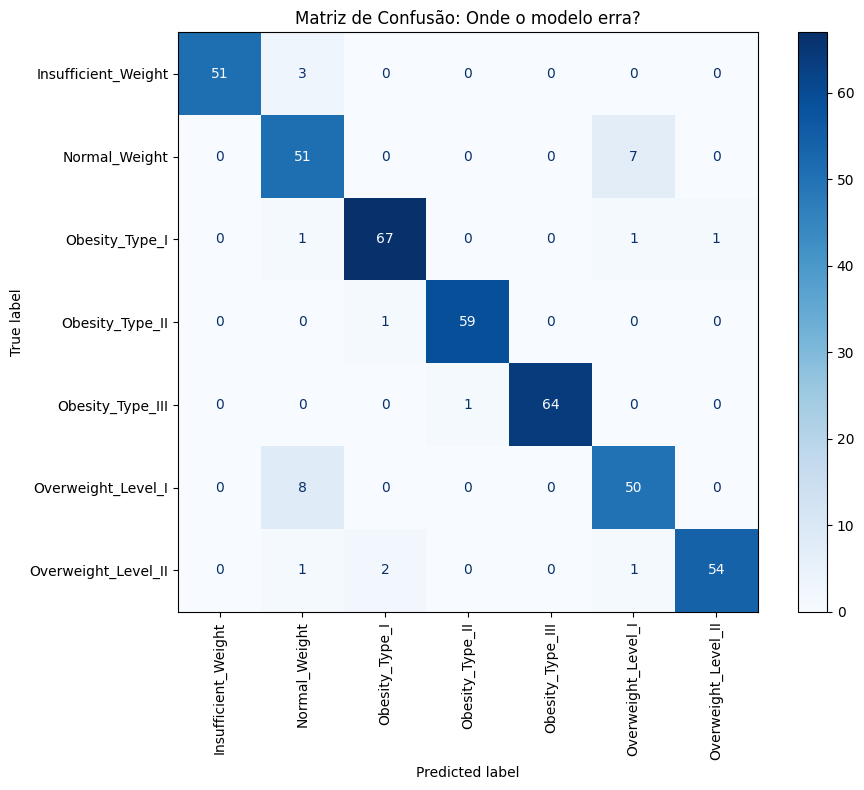


Modelo salvo com sucesso em: 'modelo_obesidade.pkl'


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib


# 1 - CARREGAMENTO E AJUSTE DOS DADOS

print("Carregando dataset...")

# Olha se o arquivo existe
arquivo = 'Obesity.csv'
if not os.path.exists(arquivo):
    raise FileNotFoundError(f"Erro: O arquivo '{arquivo}' não está na pasta!")

df = pd.read_csv(arquivo)

# LOCALIZAÇÃO AUTOMÁTICA DA COLUNA ALVO
coluna_alvo = 'Obesity' 
if coluna_alvo not in df.columns:
    # Tenta achar outro nome comum se 'Obesity' não existir
    for col in ['NObeyesdad', 'Obesity_level']:
        if col in df.columns:
            coluna_alvo = col
            break

print(f"Coluna alvo detectada: '{coluna_alvo}'")

# Separação X (Dados) e y (Target)
X = df.drop(coluna_alvo, axis=1)
y = df[coluna_alvo]


# 2 - FEATURE ENGINEERING (TRATAMENTO)

# Listas de colunas baseadas no tipo de dado
cols_numericas = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
cols_ordinais = ['CAEC', 'CALC']
cols_nominais = ['Gender', 'family_history', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']

# só processar colunas que realmente existem no arquivo
cols_numericas = [c for c in cols_numericas if c in X.columns]
cols_ordinais = [c for c in cols_ordinais if c in X.columns]
cols_nominais = [c for c in cols_nominais if c in X.columns]

# Função p/ arredondar decimais 
def arredondar_valores(X_in):
    X_out = X_in.copy()
    cols_to_round = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
    valid_cols = [c for c in cols_to_round if c in X_out.columns]
    X_out[valid_cols] = X_out[valid_cols].round().astype(int)
    return X_out

# Pipelines de transformação
transformer_num = Pipeline([
    ('arredondar', FunctionTransformer(arredondar_valores, validate=False)),
    ('scaler', StandardScaler())
])

transformer_ord = OrdinalEncoder(
    categories=[['no', 'Sometimes', 'Frequently', 'Always']] * len(cols_ordinais),
    handle_unknown='use_encoded_value', unknown_value=-1
)

transformer_nom = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', transformer_num, cols_numericas),
    ('ord', transformer_ord, cols_ordinais),
    ('nom', transformer_nom, cols_nominais)
])


# 3 - MODELAGEM (RANDOM FOREST)

# Configuração robusta para evitar Overfitting
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=100,
        max_depth=15,          
        min_samples_leaf=2,    
        random_state=42
    ))
])

# Separação Treino (80%) e Teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Treinando o modelo Random Forest...")
pipeline.fit(X_train, y_train)


# 4 - AVALIAÇÃO E PROVA REAL (OVERFITTING CHECK)

print("\n" + "_"*40)
print("RESULTADOS DA AVALIAÇÃO")

# Calcula acurácia no treino e no teste
acc_treino = pipeline.score(X_train, y_train)
acc_teste = pipeline.score(X_test, y_test)

print(f"Acurácia no Treino: {acc_treino:.2%}")
print(f"Acurácia no Teste:  {acc_teste:.2%}")

# Cálculo do Gap (Diferença)
gap = acc_treino - acc_teste

if gap > 0.10: # Se a diferença for maior que 10%
    print(f"ALERTA: Gap de {gap:.1%}. Indício de Overfitting!")
    print("   Sugestão: reduzir 'max_depth' ou aumentar 'min_samples_leaf'.")
else:
    print(f"SUCESSO: Gap controlado de apenas {gap:.1%}.")

# Relatório detalhado por classe
print("\nRelatório Detalhado por Classe (Teste):")
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


# 5 - GERAÇÃO DO GRÁFICO (MATRIZ DE CONFUSÃO)

print("\nGerando gráfico da Matriz de Confusão...")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(
    pipeline, 
    X_test, 
    y_test, 
    xticks_rotation='vertical', 
    cmap='Blues', 
    ax=ax,
    values_format='d' # Exibe valores inteiros
)
plt.title("Matriz de Confusão: Onde o modelo erra?")
plt.tight_layout()
plt.savefig('matriz_confusao.png')
print("Gráfico salvo como 'matriz_confusao.png'")
plt.show()


# 6 - SALVAR O MODELO
nome_arquivo_modelo = 'modelo_obesidade.pkl'
joblib.dump(pipeline, nome_arquivo_modelo)
print(f"\nModelo salvo com sucesso em: '{nome_arquivo_modelo}'")